### Exploratory Data Analysis of Steam data

In [42]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
playtime_df = pd.read_csv('../data/steam_playtime.csv')

In [44]:
playtime_df.sort_values(by='playtime_forever', ascending=False).head()

,appid,steam_id,playtime_2weeks,playtime_forever
1390891,10,76561197995417670,19894,5096160
330644,550,76561198152959083,20154,3083602
330659,730,76561198152959083,20154,3007440
330671,218620,76561198152959083,20154,3002293
1293636,730,76561197960828778,0,2999875


In [62]:
len(playtime_df)

2552082

### Domain knowledge based filtering

In [102]:
# drop counterstrike i.e. drop rows where appid is 730, 10 or 240
# playtime_df = playtime_df[~playtime_df['appid'].isin([730, 10, 240])]

# drop user playtimes over x minutes
playtime_df = playtime_df[playtime_df['playtime_forever'] < 10000]

In [103]:
# remove user playtimes under x minutes
playtime_df = playtime_df[playtime_df['playtime_forever'] > 60]

In [104]:
# drop extreme playtime_2weeks values, 5000 in 2 weeks equals 5.9 hours a day
playtime_df = playtime_df[playtime_df['playtime_2weeks'] < 5000]

In [228]:
playtime_df.to_csv('../data/steam_playtime_clean.csv', index=False)

### Z-SCORE

In [203]:
# get mean for playtime_forever
users_mean = playtime_df['playtime_forever'].mean()

In [204]:
# get standard deviation for playtime_forever
users_std = playtime_df['playtime_forever'].std()

In [205]:
print(users_mean, users_std)

1946.0460834854914 8110.466434837565


In [206]:
def get_zscore(value, values):
    """Obtain the z-score of a given value"""
    m = users_mean
    s = users_std
    z_score = (value - m)/s
    return np.abs(z_score)

In [207]:
# compute z-scores for all values
playtime_df['z-score'] = playtime_df['playtime_forever'].apply(lambda x: get_zscore(x, playtime_df['playtime_forever']))

# find outliers
outliers = playtime_df[playtime_df['z-score']>3]
outliers.sort_values(by='playtime_forever', ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever,z-score
686631,240,76561197985937657,645,129972,15.785276
361532,730,76561198023635244,8,129968,15.784783
1607295,363970,76561198010609680,0,129957,15.783427
1002675,730,76561198185815287,0,129940,15.781331
1245328,730,76561198063474056,0,129923,15.779235
...,...,...,...,...,...
1289265,252530,76561198121110199,0,26283,3.000685
665558,105600,76561198152228567,0,26283,3.000685
975320,730,76561198370454950,0,26280,3.000315
740808,546980,76561198389256257,0,26279,3.000192


In [208]:
# z-score too big around the 131k mark
inliers = playtime_df[playtime_df['z-score']<3]
inliers.sort_values(by='playtime_forever', ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever,z-score
1285534,33930,76561198132522077,0,26276,2.999822
859249,578080,76561198246341938,0,26276,2.999822
985797,22200,76561198266927056,0,26274,2.999575
758122,240,76561198024069963,0,26274,2.999575
1743222,200510,76561198031146329,0,26273,2.999452
...,...,...,...,...,...
2053799,743090,76561198038405441,0,11,0.238586
1907015,548680,76561197993603269,0,11,0.238586
1516758,355840,76561198089337979,0,11,0.238586
2327055,10680,76561197986837008,0,11,0.238586


In [89]:
inliers['playtime_forever'].mean()

1755.3761528011873

In [90]:
# z-score does not take care of crazy playtime_2weeks values
inliers.sort_values(by=['playtime_2weeks'], ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever,z-score
988361,1293830,76561198829679996,20122,117365,2.677608
38862,1449850,76561198282319523,20096,124043,2.834966
38820,539720,76561198282319523,20096,102833,2.335181
988354,252490,76561198829679996,20057,117609,2.683357
4368,1172470,76561198892059854,20057,43369,0.933990
...,...,...,...,...,...
806410,386070,76561198014500153,0,20,0.087472
806411,268500,76561198014500153,0,4673,0.022170
806412,427190,76561198014500153,0,624,0.073239
806413,427270,76561198014500153,0,2152,0.037234


In [230]:
inliers.to_csv('../data/steam_playtime_clean.csv', index=False)

### Interquartile Range

In [83]:
# define the lower and upper bound 
q1 = np.quantile(playtime_df['playtime_forever'], 0.25)
q3 = np.quantile(playtime_df['playtime_forever'], 0.75) 
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# find records that fall outside of the lower and upper bound
iqr_outliers = playtime_df[(playtime_df['playtime_forever']<lower_bound) | (playtime_df['playtime_forever']>upper_bound)]
iqr_outliers.sort_values(by='playtime_forever', ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever
1390891,10,76561197995417670,19894,5096160
330644,550,76561198152959083,20154,3083602
330659,730,76561198152959083,20154,3007440
330671,218620,76561198152959083,20154,3002293
1293636,730,76561197960828778,0,2999875
...,...,...,...,...
1079503,49520,76561198195312009,0,1620
1502263,457140,76561197961214342,0,1620
1197962,895400,76561198215022868,0,1620
638055,203160,76561198114091987,0,1620


In [84]:
iqr_inliers = playtime_df[(playtime_df['playtime_forever']>lower_bound) & (playtime_df['playtime_forever']<upper_bound)]
iqr_inliers.sort_values(by='playtime_forever', ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever
1109915,1531540,76561197990048103,0,1618
1375264,291650,76561198017178682,0,1618
2298142,224580,76561198010309180,0,1618
1312684,374040,76561198051468071,0,1618
2405049,107410,76561198019832554,0,1618
...,...,...,...,...
638699,453170,76561198275062480,0,1
253436,219200,76561198014563288,0,1
1360803,24780,76561197965229315,0,1
638698,468700,76561198275062480,0,1


In [85]:
iqr_inliers.sort_values(by=['playtime_2weeks'], ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever
1134172,1149460,76561198178845671,1617,1617
671479,1446780,76561198074913331,1616,1616
633060,1096530,76561198012214848,1614,1614
1834688,1996040,76561197966826746,1612,1612
1659055,1488200,76561198002604499,1608,1608
...,...,...,...,...
810396,584210,76561198007054511,0,149
810395,582500,76561198007054511,0,5
810393,568570,76561198007054511,0,1185
810392,8500,76561198007054511,0,189


In [94]:
iqr_inliers.to_csv('../data/steam_playtime_clean.csv', index=False)

### EXPLORATION & PLOTS

<AxesSubplot:xlabel='playtime_forever'>

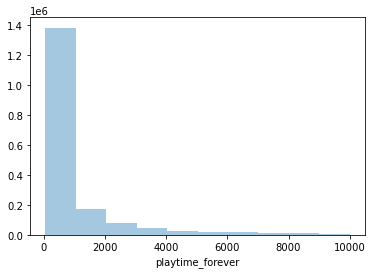

In [105]:
# plot distribution of playtime_forever
sns.distplot(playtime_df['playtime_forever'], kde=False, bins=10)

In [106]:
sort_by_2weeks = playtime_df.sort_values(by='playtime_2weeks', ascending=False)

<AxesSubplot:xlabel='playtime_2weeks'>

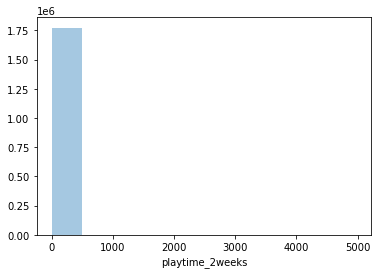

In [107]:
# plot sort_by_2weeks
sns.distplot(sort_by_2weeks['playtime_2weeks'], kde=False, bins=10)


In [108]:
# sort by playtime_forever
sort_by_playtime = playtime_df.sort_values(by = ['playtime_forever'], ascending = False).reset_index()

<AxesSubplot:ylabel='Frequency'>

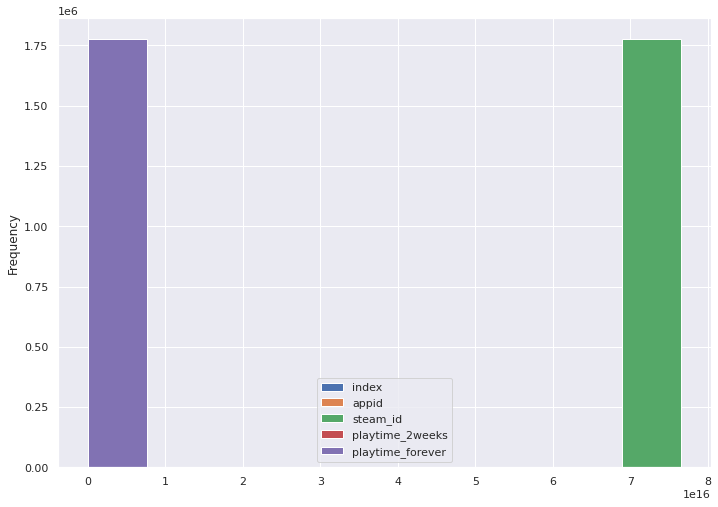

In [120]:
# plot distribution of playtimes
sort_by_playtime.plot(kind = 'hist')

In [192]:
sort_by_playtime

,index,appid,steam_id,playtime_2weeks,playtime_forever
0,686631,240,76561197985937657,645,129972
1,361532,730,76561198023635244,8,129968
2,1607295,363970,76561198010609680,0,129957
3,1002675,730,76561198185815287,0,129940
4,1245328,730,76561198063474056,0,129923
...,...,...,...,...,...
2143584,366091,1151640,76561197966665386,0,11
2143585,1836386,70600,76561197980891330,0,11
2143586,2363325,357480,76561197991856426,0,11
2143587,2329090,241540,76561198035823175,0,11


<AxesSubplot:>

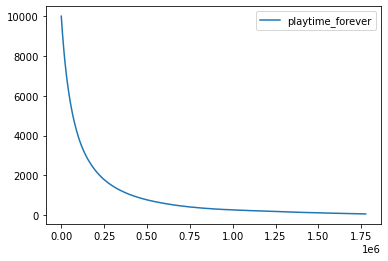

In [109]:
sort_by_playtime.plot(y='playtime_forever', use_index=True)

<AxesSubplot:xlabel='playtime_forever', ylabel='Count'>

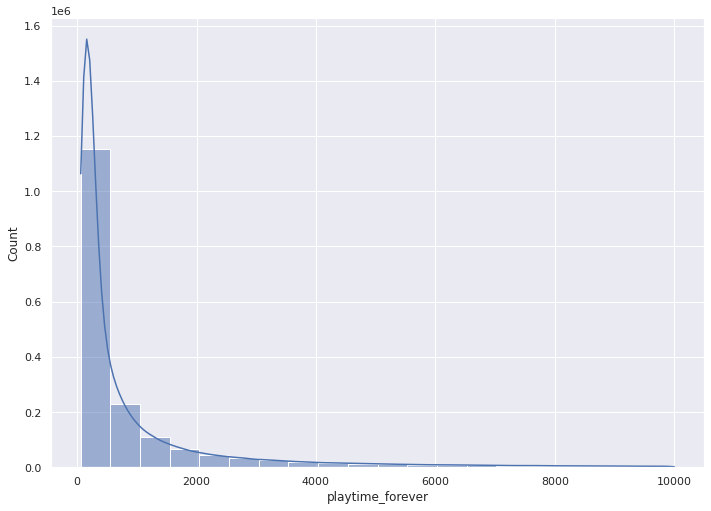

In [110]:
# plot sort_by_playtime
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(sort_by_playtime['playtime_forever'], bins = 20, kde = True)


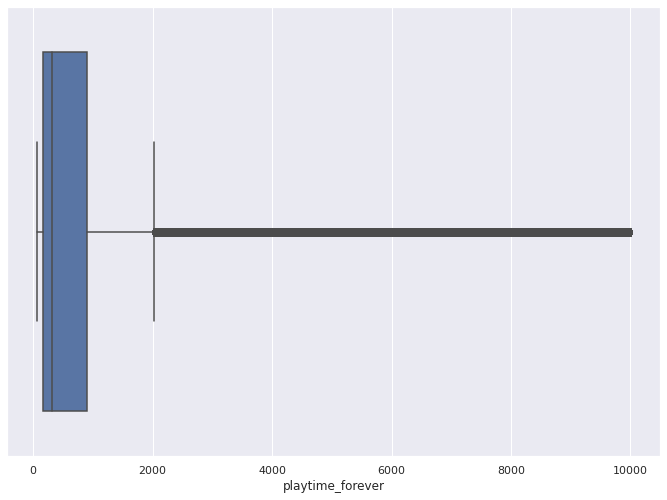

In [111]:
sns.boxplot(x=sort_by_playtime['playtime_forever'])
plt.show()

In [113]:
# group by appid and get count, mean, median, min, max
playtime_by_game = playtime_df.groupby('appid').agg({'playtime_forever': ['count', 'mean', 'median', 'min', 'max']}).round(2)

In [114]:
# sort by mean
playtime_by_game.sort_values(by=('playtime_forever', 'mean'), ascending=False)

playtime_forever                            
                   count    mean  median   min   max
appid                                               
44670                  1  9942.0  9942.0  9942  9942
44650                  1  9942.0  9942.0  9942  9942
44660                  1  9942.0  9942.0  9942  9942
526780                 1  9918.0  9918.0  9918  9918
626200                 1  9502.0  9502.0  9502  9502
...                  ...     ...     ...   ...   ...
853200                 1    61.0    61.0    61    61
628530                 1    61.0    61.0    61    61
2004490                1    61.0    61.0    61    61
1027190                1    61.0    61.0    61    61
321610                 1    61.0    61.0    61    61

[21634 rows x 5 columns]

In [117]:
# sort by count
playtime_by_game.sort_values(by=('playtime_forever', 'count'), ascending=True)

playtime_forever                           
                   count     mean median  min   max
appid                                              
592130                 1   228.00  228.0  228   228
1288790                1    62.00   62.0   62    62
337130                 1   654.00  654.0  654   654
723830                 1   855.00  855.0  855   855
723890                 1    73.00   73.0   73    73
...                  ...      ...    ...  ...   ...
4000                6260  1970.22  918.5   61  9986
945360              6598  1214.18  662.5   61  9942
218620              7166  1764.09  805.5   61  9993
620                 7355  1067.25  711.0   61  9962
550                 9088  1574.60  769.5   61  9981

[21634 rows x 5 columns]

In [118]:
# playtime_by_game where count is 1
playtime_by_game[playtime_by_game[('playtime_forever', 'count')] == 1]

playtime_forever                        
                   count   mean median  min  max
appid                                           
1920                   1   99.0   99.0   99   99
3000                   1   81.0   81.0   81   81
3340                   1   69.0   69.0   69   69
3400                   1  133.0  133.0  133  133
3510                   1   79.0   79.0   79   79
...                  ...    ...    ...  ...  ...
2176130                1  408.0  408.0  408  408
2185780                1   61.0   61.0   61   61
2186680                1  521.0  521.0  521  521
2215260                1   74.0   74.0   74   74
2216360                1   67.0   67.0   67   67

[3795 rows x 5 columns]

Text(0.5, 0, 'Game')

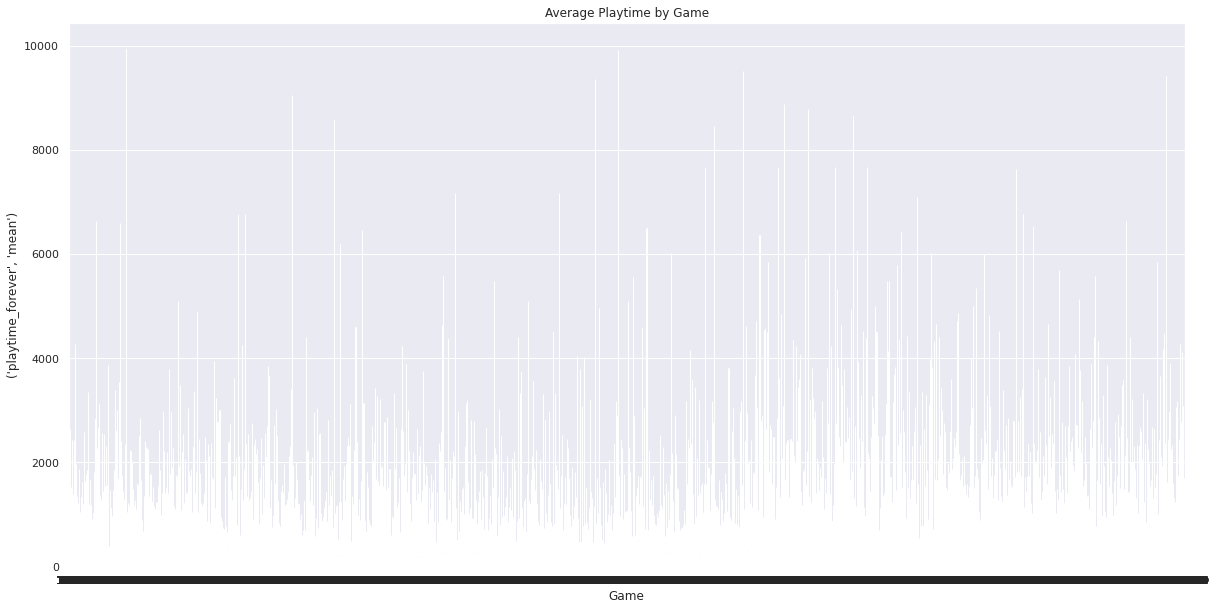

In [119]:
# plot playtime by game
plt.figure(figsize=(20,10))
sns.barplot(x=playtime_by_game.index, y = playtime_by_game[('playtime_forever', 'mean')])
plt.title('Average Playtime by Game')
plt.xlabel('Game')


In [214]:
# get appids where count is 1
only_one_playtime = playtime_by_game[playtime_by_game[('playtime_forever', 'count')] == 1].index

In [216]:
# exclude games with only one playtime
playtime_df = playtime_df[~playtime_df['appid'].isin(only_one_playtime)]

In [217]:
playtime_df

,appid,steam_id,playtime_2weeks,playtime_forever,z-score
0,240,76561198015529005,0,315,0.201104
1,300,76561198015529005,0,90,0.228846
3,340,76561198015529005,0,45,0.234394
4,10180,76561198015529005,0,1406,0.066586
5,10190,76561198015529005,0,17051,1.862403
...,...,...,...,...,...
2440100,1517290,76561198071594531,0,1744,0.024912
2440101,1522820,76561198071594531,0,636,0.161525
2440102,1248130,76561198071594531,0,5867,0.483444
2440104,1252330,76561198071594531,0,90,0.228846


### GAME METADATA

In [81]:
games_df = pd.read_csv('../data/steam_app_metadata.csv')

In [88]:
games_df

,appid,name,description,developer,publisher,categories,genres
0,240,Counter-Strike: Source,THE NEXT INSTALLMENT OF THE WORLD'S # 1 ONLINE...,Valve,Valve,"['Multi-player', 'Cross-Platform Multiplayer',...",['Action']
1,300,Day of Defeat: Source,Day of Defeat offers intense online action gam...,Valve,Valve,"['Multi-player', 'Cross-Platform Multiplayer',...",['Action']
2,320,Half-Life 2: Deathmatch,Fast multiplayer action set in the Half-Life 2...,Valve,Valve,"['Multi-player', 'Valve Anti-Cheat enabled', '...",['Action']
3,340,Half-Life 2: Lost Coast,Originally planned as a section of the Highway...,Valve,Valve,"['Single-player', 'Commentary available', 'Rem...",['Action']
4,10180,Call of Duty®: Modern Warfare® 2,The most-anticipated game of the year and the ...,Infinity Ward,Activision,"['Single-player', 'Multi-player', 'Co-op', 'St...",['Action']
...,...,...,...,...,...,...,...
25510,1715980,Bail or Jail(OBAKEIDORO!),"<img src=""https://cdn.akamai.steamstatic.com/s...","FREE STYLE, Inc.",Konami Digital Entertainment,"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'Casual', 'Sports']"
25511,1785000,Mokoko X,"<h2 class=""bb_tag"">About</h2>Mokoko X was insp...",NAISU,NAISU,"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Casual', 'Indie']"
25512,1846920,Lust Academy - Season 1,"<img src=""https://cdn.akamai.steamstatic.com/s...",Bear in the Night,Bear in the Night,"['Single-player', 'Steam Achievements', 'Steam...","['Adventure', 'Casual', 'Indie']"
25513,611300,Task Force,<h1>Workshop Support</h1><p>Task Force provide...,Tracer Interactive,Tracer Interactive,"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...","['Action', 'Indie', 'Strategy', 'Early Access']"


In [83]:
# show duplicates for appid
games_df[games_df.duplicated(subset=['appid'])]

,appid,name,description,developer,publisher,categories,genres
21233,240,Counter-Strike: Source,THE NEXT INSTALLMENT OF THE WORLD'S # 1 ONLINE...,Valve,Valve,"['Multi-player', 'Cross-Platform Multiplayer',...",['Action']
21234,300,Day of Defeat: Source,Day of Defeat offers intense online action gam...,Valve,Valve,"['Multi-player', 'Cross-Platform Multiplayer',...",['Action']
21235,320,Half-Life 2: Deathmatch,Fast multiplayer action set in the Half-Life 2...,Valve,Valve,"['Multi-player', 'Valve Anti-Cheat enabled', '...",['Action']


In [84]:
# remove duplicate appid
games_df = games_df.drop_duplicates(subset=['appid'])

In [85]:
# get duplicates for name
dupl_game_names = games_df[games_df.duplicated(subset=['name'])]

In [86]:
# rename appid's in users_df that are duplicates to original appid
for index, row in dupl_game_names.iterrows():
    dupl_appid = row['appid']
    orig_appid = games_df[games_df['name'] == row['name']]['appid'].iloc[0]
    playtime_df.loc[playtime_df['appid'] == dupl_appid, 'appid'] = orig_appid


In [87]:
# remove duplicates from games_df
games_df = games_df.drop_duplicates(subset=['name'])

In [100]:
# count nulls for each column
games_df.isnull().sum()

appid          0
name           0
description    0
developer      0
publisher      0
categories     0
genres         0
dtype: int64

In [96]:
no_description = games_df[games_df['description'].isnull() | (games_df['description'] == '')]
games_df = games_df[~games_df['appid'].isin(no_description['appid'])]

In [97]:
no_dev_or_pub = games_df[(games_df['developer'] == 'None') & games_df['publisher'].isnull()]
games_df = games_df[~games_df['appid'].isin(no_dev_or_pub['appid'])]

In [98]:
# impute developer into publisher where publisher is null
games_df['publisher'] = games_df['publisher'].fillna(games_df['developer'])

In [99]:
# get average 'description' length
print('mean is', games_df['description'].str.len().mean().__round__(), 'characters')
print('median is', games_df['description'].str.len().median(), 'characters')

mean is 1990 characters
median is 1620.0 characters


In [73]:
# get average 'description' length
games_df[games_df['description'].str.len() > 10000]

,appid,name,description,developer,publisher,categories,genres
53,218230,PlanetSide 2,"<h1>Expedition: Oshur</h1><p><img src=""https:/...",Rogue Planet Games,Daybreak Game Company,"['Multi-player', 'MMO', 'PvP', 'Online PvP', '...","['Action', 'Free to Play', 'Massively Multipla..."
79,346110,ARK: Survival Evolved,"<h1>ARK: Genesis Part Two!</h1><p><a href=""htt...",Studio Wildcard,Studio Wildcard,"['Single-player', 'Multi-player', 'MMO', 'Co-o...","['Action', 'Adventure', 'Indie', 'Massively Mu..."
297,369990,"Gremlins, Inc.","<h1>OFFICIAL DISCORD SERVER</h1><p><a href=""ht...",Charlie Oscar Lima Tango Interactive Entertain...,The Merchant Guild of Rund (Limited),"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Indie', 'Strategy']"
350,451340,Gold Rush: The Game,"<h1>Check out other games!</h1><p><a href=""htt...",Code Horizon,Code Horizon,"['Single-player', 'Full controller support', '...","['Indie', 'Simulation']"
599,979110,Space Haven,"<img src=""https://cdn.akamai.steamstatic.com/s...",Bugbyte Ltd.,Bugbyte Ltd.,"['Single-player', 'Full controller support', '...","['Indie', 'RPG', 'Simulation', 'Strategy', 'Ea..."
...,...,...,...,...,...,...,...
23730,1309610,Line War,<h1>Roadmap</h1><p>Line War will continue to e...,Studio Centurion,Studio Centurion,"['Multi-player', 'PvP', 'Online PvP']",['Strategy']
24639,1136380,Ultimate Fishing Simulator 2,<h1>SPECIAL DISCOUNT for Ultimate Fishing Simu...,MasterCode,Ultimate Games S.A.,"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Casual', 'Simulation', 'Sports', 'Early Acce..."
25186,1985930,The Backrooms 1998 - Found Footage Survival Ho...,"<img src=""https://cdn.akamai.steamstatic.com/s...",Steelkrill Studio,Steelkrill Studio,"['Single-player', 'Multi-player', 'Co-op']","['Action', 'Adventure', 'Indie', 'Simulation',..."
25259,1450800,Lilith Odyssey,"<h1>DISCORD</h1><p><img src=""https://cdn.akama...",Chaystar Unlimited LLC,Chaystar Unlimited LLC,"['Single-player', 'Steam Achievements']",['Adventure']
